In [1]:
import torch
import numpy as np

from torch import nn, optim
import torch.nn.functional as F
from sklearn.preprocessing import OneHotEncoder

import matplotlib.pyplot as plt
import seaborn as sns

In [33]:
# Define a model:
class Network(nn.Module):
    def __init__(self, vocab, n_hidden, n_layers, do=0.5):
        super().__init__()
        
        self.vocab    = vocab
        self.int2char = {i: ch for i, ch in enumerate(vocab)}
        self.char2int = {ch: i for i, ch in self.int2char.items()}
        self.encoder  = OneHotEncoder(sparse=False).fit(vocab.reshape(-1, 1))
        
        self.n_hidden = n_hidden 
        self.n_layers = n_layers
        self.lstm = nn.LSTM(len(vocab), n_hidden, n_layers, batch_first=True, dropout=do)
        self.fc   = nn.Linear(n_hidden, len(vocab))
        
    def forward(self, x, hs=None):
        x, hs = self.lstm(x, hs)          # -> (batch_size, seq_len, n_hidden)
        x = x.reshape(-1, self.n_hidden)  # -> (batch_size * seq_len, n_hidden)
        out = self.fc(x)                  # -> (batch_size * seq_len, vocab_size)
        
        return out, hs 
    
    def predict(self, char, top_k=None, hs=None):
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.to(device)
        self.eval()
        
        with torch.no_grad():
            x = np.array([char])
            x = x.reshape(-1, 1)
            x = self.onehot_encode(x)
            x = x.reshape(1, 1, -1)
            x = torch.tensor(x, dtype=torch.float32)
            x = x.to(device)

            out, hs = self(x, hs)

            ps   = F.softmax(out, dim=1).squeeze()
            
            if top_k is None:
                choices = np.arange(len(self.vocab))
            else:
                ps, choices = ps.topk(top_k)
                choices = choices.cpu().numpy()
            
            ps = ps.cpu().numpy()
            
            char = np.random.choice(choices, p=ps/ps.sum())
            char = self.int2char[char]

        return char, hs
    
    
    def sample(self, length, top_k=None, primer='And Victoria sang '):
        hs = None
        for px in primer:
            out, hs = self.predict(px, hs=hs)
        
        chars = [ch for ch in primer]
        for ix in range(length):
            char, hs = self.predict(chars[-1], top_k=top_k, hs=hs)
            chars.append(char)
        
        return ''.join(chars)
    
    
    def label_encode(self, data):
        return np.array([self.char2int[ch] for ch in data])
    
    
    def label_decode(self, data):
        return np.array([self.int2char[i] for i in data])
    
    
    def onehot_encode(self, data):
        return self.encoder.transform(data)
    
    
    def onehot_decode(self, data):
        return self.encoder.inverse_transform(data)
        
        

In [3]:
# define a batching method:
def get_batches(data, n_seq, seq_len):
    """
    Takes data of shape (n_samples, n_features), returns batches
    of shape (n_seq, seq_len, n_features)
    """
    n_features = data.shape[1]
    n_chars    = n_seq * seq_len
    n_batches  = int(np.floor(len(data) / n_chars))
    n_keep     = n_batches * n_chars
    
    inputs  = data[:n_keep]
    targets = np.append(data[1:], data[0]).reshape(data.shape)
    targets = targets[:n_keep]
    
    inputs = inputs.reshape(n_seq, -1, n_features)
    targets = targets.reshape(n_seq, -1, n_features)
    
    for i in range(0, inputs.shape[1], seq_len):
        x = inputs[:, i: i + seq_len]
        y = targets[:, i: i + seq_len]
        yield x,y
        

In [4]:
def train(model, data, batch_size, seq_len, epochs, lr=0.01, clip=5, valid=None):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = model.to(device)
    
    opt = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    if valid is not None:
        data  = model.onehot_encode(data.reshape(-1, 1))
        valid = model.onehot_encode(valid.reshape(-1, 1))
    else:
        data  = model.onehot_encode(data.reshape(-1, 1))

    train_loss = []
    valid_loss = []
    
    for e in range(epochs):
        model.train()
        hs = None
        t_loss = 0
        v_loss = 0

        for x, y in get_batches(data, batch_size, seq_len):
            opt.zero_grad()
            x = torch.tensor(x).float()
            x = x.to(device)
            
            out, hs = model(x, hs)
            hs = tuple([h.data for h in hs])

            # invert one-hot of targets for use by cross-entropy loss function
            y = y.reshape(-1, len(model.vocab))
            y = model.onehot_decode(y)
            y = model.label_encode(y.squeeze())
            y = torch.from_numpy(y).long().to(device)

            loss = criterion(out, y.squeeze())
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), clip)
            opt.step()
            
            t_loss += loss.item()
            
        if valid is not None:
            model.eval()
            hs = None
            with torch.no_grad():
                for x, y in get_batches(valid, batch_size, seq_len):

                    x = torch.tensor(x).float()
                    x = x.to(device)

                    # invert one-hot of targets for use by cross-entropy loss function
                    y = y.reshape(-1, len(model.vocab))
                    y = model.onehot_decode(y)
                    y = model.label_encode(y.squeeze())
                    y = torch.from_numpy(y).long().to(device)

                    out, hs = model(x, hs)
                    hs = tuple([h.data for h in hs])

                    loss = criterion(out, y.squeeze())
                    v_loss += loss.item()

                valid_loss.append(np.mean(v_loss))
        
        train_loss.append(np.mean(t_loss))
        
        if e % 2 == 0:
            print(f'------- Epoch {e} ---------')
            print(f'Training Loss: {train_loss[-1]}')
            if valid_loss:
                print(f'Valid Loss: {valid_loss[-1]}')
            
    plt.plot(train_loss, label="Training")
    plt.plot(valid_loss, label="Validation")
    plt.title("Loss vs Epochs")
    plt.legend()
    plt.show()

In [6]:
# get data from file:
with open('data/texts/anna.txt') as data:
    text = data.read()

# get unique characters in text 
vocab = np.array(sorted(set(text)))

# split training and validation sets. Convert text to NumPy arrays
split_idx = int(np.floor(0.1 * len(text)))
trainset = np.array(list(text[:-split_idx]))
validset = np.array(list(text[-split_idx:]))
trainset.shape, validset.shape

((1786701,), (198522,))

In [7]:
n_hidden = 390
n_layers = 2

model = Network(vocab, n_hidden, n_layers)
model

Network(
  (lstm): LSTM(83, 390, num_layers=2, batch_first=True, dropout=0.5)
  (fc): Linear(in_features=390, out_features=83, bias=True)
)

------- Epoch 0 ---------
Training Loss: 146.75550657510757
Valid Loss: 18.77520525455475
------- Epoch 2 ---------
Training Loss: 143.57203900814056
Valid Loss: 18.782105326652527
------- Epoch 4 ---------
Training Loss: 142.20537877082825
Valid Loss: 18.79310667514801
------- Epoch 6 ---------
Training Loss: 141.17436909675598
Valid Loss: 18.854512333869934
------- Epoch 8 ---------
Training Loss: 140.2795495390892
Valid Loss: 18.914209842681885


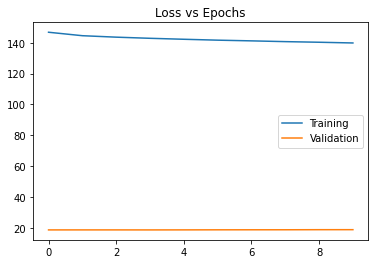

In [10]:
batch_size = 128
seq_len = 100
epochs = 10
lr = 0.001

train(model, trainset, batch_size, seq_len, epochs, lr=lr, valid=validset)

In [11]:
checkpoint = {
    'vocab'   : model.vocab,
    'n_hidden': model.n_hidden,
    'n_layers': model.n_layers,
    'state'   : model.state_dict()
}

filepath = 'saved/LSTM_390_nodes_25_epochs.net'

with open(filepath, 'wb') as f:
    torch.save(checkpoint, f)

In [34]:
with open('saved/LSTM_390_nodes_25_epochs.net', 'rb') as f:
    checkpoint = torch.load(f)

model = Network(vocab, checkpoint['n_hidden'], checkpoint['n_layers'])
model.load_state_dict(checkpoint['state'])

<All keys matched successfully>

In [35]:
text = model.sample(1000, top_k=5)

In [36]:
print(text)

And Victoria sang he saw that it was a long
while, to her face, and he concealed her. She had not supposed that she was told
the same thing had been
so firmly
and husbands from his comrades. Tenthed the stream at the moment in the point of plangers, was the same step over the steps.

"Well, I'm a machine, but I am to stand to
see you and that her son have no more."

"Oh, no!" she added, letting in her strong arms.

"The second moment's saying how to do it, but it's to be so much!" said the
driving and deliberate scarcely, shrugging officers, with a smile alone all the
same thing that had set to the man in his face with a smile to Varenka. Alexey
Alexandrovitch had tried not to get them. And the family was so strength.



Chapter 29


When he was tried to disten on, a spiritualist which is, they were aware, and the stretch of color, and her mother's secretary had never been dreaming. She was a conversation that still more, while
a short-conversation or his
face, and the dog that had bee